<a href="https://colab.research.google.com/github/jmestanza/Echo_cancellation/blob/master/BadImplementationOfFBLMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Obtención de datos de prueba para los algoritmos

In [9]:
from IPython.display import clear_output

!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_lento.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_lento.wav"

clear_output()

import warnings
warnings.filterwarnings("ignore")
from scipy.io.wavfile import read
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy import *

def sync_signals(u,d,init_delay,evLen,fs):
    u = u[int(0):int((evLen)*fs)]
    d = d[int((init_delay)*fs):int((init_delay+evLen)*fs)]
    return u, d

def adjustSignals(fs,u,d):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))

    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ

def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos


def read_wavs(audio_file,grab_file):
    file_name = grab_file
    fs, grab_audio = get_mono_array(file_name)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio = grab_audio - np.mean(grab_audio)
    print("fs de la grabacion ",fs, "nombre", file_name)

    file_name = audio_file
    fs, audio = get_mono_array(file_name)

    audio /= np.max(np.abs(audio),axis=0)
    audio = audio-np.mean(audio)
    print("fs del audio ",fs, "nombre", file_name)
    return audio,grab_audio,fs

signals = {'log':['/content/sweep_lento.wav','/content/grab_sweep_lento.wav',0.648,10.936]}

sound="log"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


fs de la grabacion  48000 nombre /content/grab_sweep_lento.wav
fs del audio  48000 nombre /content/sweep_lento.wav


(0.0, 100.0)

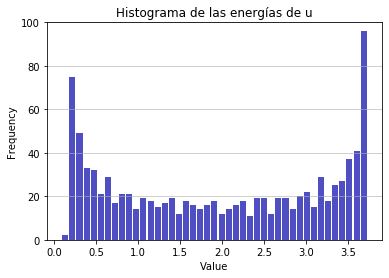

In [10]:
#ploteo de las energías de u en histograma para NLMS
n, bins, patches = plt.hist(x=energias_u, bins=43, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de las energías de u')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

##Fast Block LMS (con picos)

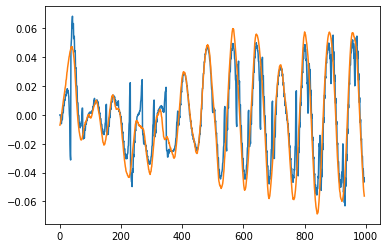

In [11]:
def normalize(datos):
    datos -= np.mean(datos)
    datos = np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
    return datos


def getBlock(M,subArray,k):
    block = np.zeros((M,M))
    for i in range(M):
        block[:,i] = np.flip(subArray[(k*M +i): (k*M +i+M)])
    return block
def getBlocks(M,number_of_blocks,new_u,new_d):
    blocks_u = []
    blocks_d = []
    for i in range(number_of_blocks):
        blocks_u.append(getBlock(M,new_u,i)) 
        blocks_d.append(getBlock(M,new_d,i))

    blocks_u = np.array(blocks_u)
    blocks_d = np.array(blocks_d)
    return blocks_u, blocks_d

def FastBlockNLMS(M, u, d, mu, delta, gamma):
    N = 2*M
    u_list = np.zeros(0)
    d_list = np.zeros(0)
    y_list = np.zeros(0)

    W = np.zeros(N)
    W = W.astype(complex)
    original_len = len(u)
    
    new_u = np.concatenate((np.zeros(M-1),u), axis= None)
    new_d = np.concatenate((np.zeros(M-1),d), axis= None)

    number_of_blocks = original_len//M

    blocks_u, blocks_d = getBlocks(M, number_of_blocks, new_u,new_d)

    
    # el algoritmo empieza aca
    for k in range(number_of_blocks - 1):
    #for k in range(2):
        u_list = np.concatenate((u_list,blocks_u[k][0,:]), axis=None)

        # concateno dos bloques
        u_concat = np.concatenate((blocks_u[k],blocks_u[k+1]),axis=1)
        u_concat = np.concatenate((u_concat,np.zeros((M,N))), axis = 0) # overlap and save
        u_concat = u_concat.astype(complex)
        for i in range(N):
            #u_concat[:,i] = np.fft.fft(u_concat[:,i]) # esto hace la fft en columnas
            u_concat[i,:] = np.fft.fft(u_concat[i,:]) # esto hace la fft en filas
            # da mejor con las filas, ademas en el resumen dice que haga fft de la cosa traspuesta 
        
        U = u_concat.diagonal() # esta U es de longitud N = 2M
        #print(U)
        y = np.fft.ifft(U*W).real
        y = y[len(y)-M:] 
        y_list = np.concatenate((y_list,y), axis=None)
        d = blocks_d[k][0,:]

        d_list = np.concatenate((d_list,d), axis=None)

        e = d-y
        E = np.fft.fft(np.concatenate((np.zeros(M),e),axis = None))
        phi = np.fft.ifft((U.conj().T)*E).real[:M]

        W += (gamma/(np.sum(np.power(np.abs(U),2))))*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))
      
    return u_list,y_list, d_list

auxu = uZ[len(uZ)//2:len(uZ)//2+1000]
auxd = dZ[len(dZ)//2:len(dZ)//2+1000]

u_list, y_list, d_list =FastBlockNLMS(3,auxu,auxd, mu = 0.1, delta=0.1, gamma = 3)

#print(y_list)
plt.plot(y_list)
plt.plot(d_list)

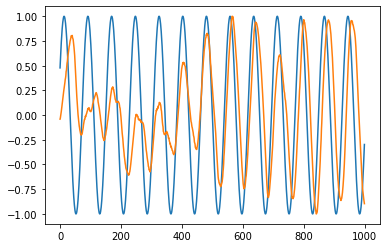

In [12]:
plt.plot(normalize(auxu))
plt.plot(normalize(auxd))

##Fast Block LMS (estilo NLMS) 

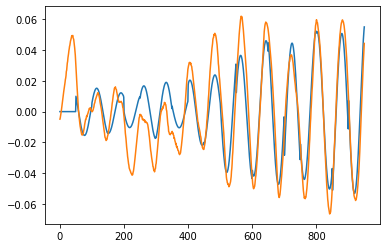

In [14]:
def FastBlockNLMS(M, u, d, mu, delta):
    N = 2*M
    u_list = np.zeros(0)
    d_list = np.zeros(0)
    y_list = np.zeros(0)

    W = np.zeros(N)
    W = W.astype(complex)
    original_len = len(u)
    
    new_u = np.concatenate((np.zeros(M-1),u), axis= None)
    new_d = np.concatenate((np.zeros(M-1),d), axis= None)

    number_of_blocks = original_len//M

    blocks_u, blocks_d = getBlocks(M, number_of_blocks, new_u,new_d)

    
    # el algoritmo empieza aca
    for k in range(number_of_blocks - 1):
        u_list = np.concatenate((u_list,blocks_u[k][0,:]), axis=None)

        # concateno dos bloques
        u_concat = np.concatenate((blocks_u[k],blocks_u[k+1]),axis=1)
        u_concat = np.concatenate((u_concat,np.zeros((M,N))), axis = 0) # overlap and save
        u_concat = u_concat.astype(complex)
        for i in range(N):
            #u_concat[:,i] = np.fft.fft(u_concat[:,i]) # esto hace la fft en columnas
            u_concat[i,:] = np.fft.fft(u_concat[i,:]) # esto hace la fft en filas
            # da mejor con las filas, ademas en el resumen dice que haga fft de la cosa traspuesta 
        
        U = u_concat.diagonal() # esta U es de longitud N = 2M
        y = np.fft.ifft(U*W).real
        
        y = y[len(y)-M:] 
        y_list = np.concatenate((y_list,y), axis=None)
        d = blocks_d[k][0,:]

        d_list = np.concatenate((d_list,d), axis=None)

        e = d-y
        E = np.fft.fft(np.concatenate((np.zeros(M),e),axis = None))
        phi = np.fft.ifft((U.conj().T)*E).real[:M]
        nu = mu/(np.dot(blocks_u[k][0,:],blocks_u[k][0,:]) + delta)
        W += nu*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))
    return u_list,y_list, d_list

auxu = uZ[len(uZ)//2:len(uZ)//2+1000]
auxd = dZ[len(dZ)//2:len(dZ)//2+1000]

u_list, y_list, d_list =FastBlockNLMS(50,auxu,auxd, mu = 0.1, delta=0.1)

plt.plot(y_list)
plt.plot(d_list)

##Fast Block LMS (con opciones de mejora conv y pot)

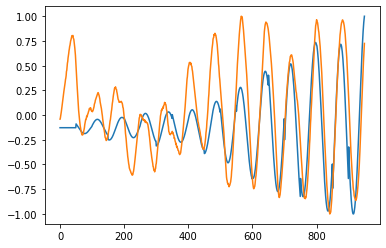

In [15]:
def FastBlockNLMS(M, u, d, delta, gamma, mode):
    N = 2*M
    d_list = np.zeros(0)
    y_list = np.zeros(0)
    W = np.zeros(N)
    W = W.astype(complex)
    original_len = len(u)
    P = np.zeros((N,N))
    P[:,-1] = np.ones(N)*delta # init de P
     
    new_u = np.concatenate((np.zeros(M-1),u), axis= None)
    new_d = np.concatenate((np.zeros(M-1),d), axis= None)

    number_of_blocks = original_len//M

    blocks_u, blocks_d = getBlocks(M, number_of_blocks, new_u,new_d)

    # el algoritmo empieza aca    
    for k in range(number_of_blocks - 1):    
        u_concat = np.concatenate((blocks_u[k],blocks_u[k+1]),axis=1) # concateno dos bloques
        u_concat = np.concatenate((u_concat,np.zeros((M,N))), axis = 0) # overlap and save
        u_concat = u_concat.astype(complex)
        for i in range(N):
            u_concat[i,:] = np.fft.fft(u_concat[i,:]) # esto hace la fft en filas
        U = u_concat.diagonal() # esta U es de longitud 2N  
        for l in range(N):
            P[:,l] = gamma* P[:,l-1] + (1-gamma)* np.power(np.abs(U),2)

        D = np.power(P.diagonal(),-1)
        y = np.fft.ifft(U*W).real
        y = y[len(y)-M:] 
        y_list = np.concatenate((y_list,y), axis=None)
        d = blocks_d[k][0,:]
        d_list = np.concatenate((d_list,d), axis=None)
        e = d-y
        E = np.fft.fft(np.concatenate((np.zeros(M),e),axis = None))
        if mode == "pot":
            pot = np.sum(np.power(np.abs(U),2))
            phi = np.fft.ifft(U.conj()*E).real[:M] 
            W += (gamma/pot)*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))
        elif mode == "mejorconv":
            phi = np.fft.ifft(np.matmul(D,U.conj().T)*E).real[:M] 
            W += gamma*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))

    return y_list, d_list

auxu = uZ[len(uZ)//2:len(uZ)//2+1000]
auxd = dZ[len(dZ)//2:len(dZ)//2+1000]

y_list, d_list =FastBlockNLMS(50,auxu,auxd, delta=0.01, gamma = 0.9, mode = "pot")

plt.plot(normalize(y_list))
plt.plot(normalize(d_list))